In [109]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import random_split, TensorDataset, DataLoader

In [110]:
seed = 123
dtype = torch.float32
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
torch.set_default_device(device)
torch.manual_seed(seed)
generator = torch.Generator(device=device).manual_seed(seed)

In [111]:
def lin_fn(X):
    return 3 * X + 2

def generate_linear_data(size):
    X = torch.arange(0, size, dtype=dtype, device=device).unsqueeze(1)
    y = lin_fn(X)

    X_mean = X.mean()
    X_std = X.std()
    X = (X - X_mean) / X_std

    y_mean = y.mean()
    y_std = y.std()
    y = (y - y_mean) / y_std

    return X, y, X_mean, y_mean, X_std, y_std

total_size = 1000
X_dataset, y_dataset, X_mean, y_mean, X_std, y_std = generate_linear_data(total_size)
dataset = TensorDataset(X_dataset, y_dataset)

train_size = int(total_size * 0.6)
val_size = int(total_size * 0.2)
test_size = int(total_size * 0.2)

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=generator)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, generator=generator)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, generator=generator)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, generator=generator)


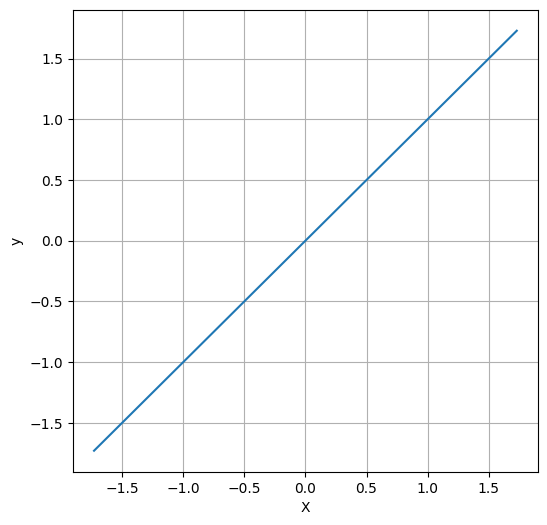

In [112]:
def plot_linear_data(X, y):
    plt.figure(figsize=(6,6))
    plt.plot(X.cpu(), y.cpu(), label = 'line')
    plt.xlabel("X")
    plt.ylabel("y")
    plt.grid(True)
    plt.show()

plot_linear_data(X_dataset, y_dataset)

In [113]:
class LinearRegression(nn.Module):

    def __init__(self, input_size, output_size):
        super().__init__()
        self.linear_layer = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear_layer(x)

In [114]:
epoch = 5
print_per_epoch = 1

def predict(model, x_raw, x_mean, x_std, y_mean, y_std):
    x_norm = (x_raw - x_mean) / x_std
    y_norm = model(x_norm)
    return y_norm * y_std + y_mean

def accuracy(model, test_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for _, data in enumerate(test_loader):
            inputs, labels = data
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)  
            correct += (predicted == labels).sum().item() 
            total += labels.size(0)
    return correct / total

def eval(model, loss_fn, val_loader):
    running_loss = 0
    model.eval()

    with torch.no_grad():
        for _, data in enumerate(val_loader):
            inputs, labels = data

            y_pred = model(inputs)

            loss = loss_fn(y_pred, labels)
            running_loss += loss.item()
    return running_loss / len(val_loader)

def train(model, loss_fn, optimizer, train_loader, val_loader):
    model.train()

    for i in range(epoch):
        running_loss = 0
        for _, batch in enumerate(train_dataset):
            X, y = batch
            
            optimizer.zero_grad()

            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            running_loss += loss.item()

            loss.backward()

            optimizer.step()
        train_loss_avg = running_loss / len(train_loader)
        val_loss_avg = eval(model, loss_fn, val_loader)

        if (i+1)%print_per_epoch == 0:
            print('LOSS train {:.8f} valid {:.8f}'.format(train_loss_avg, val_loss_avg))


In [115]:
input_size = 1
output_size = 1
learning_rate = 1e-2

model = LinearRegression(input_size, output_size)
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

train(model, loss_fn, optimizer, train_loader, val_loader)
# acc = accuracy(model, test_loader)

# print('ACC {}'.format(acc))

model.eval()
input = 4444.0 #never seen input
y_pred = predict(model, torch.tensor([[input]], device=device), X_mean, X_std, y_mean, y_std)
print("Predicted: ", y_pred.item())
print("Actual: ", lin_fn(input))


LOSS train 4.81814138 valid 0.00000000
LOSS train 0.00000000 valid 0.00000000
LOSS train 0.00000000 valid 0.00000000
LOSS train 0.00000000 valid 0.00000000
LOSS train 0.00000000 valid 0.00000000
Predicted:  13333.994140625
Actual:  13334.0
